In [1]:
import numpy as np
import pandas as pd
import math
import os
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import deque
from sklearn import metrics
from functools import wraps
from time import time
import ot
from pathlib import Path
import time

n = 1000
x_dim = 2
epsilon = 1
eps = str(epsilon).replace(".", "_")
b = 0.5
bet = str(b).replace(".", "_")
hiddens = [x_dim + 1, 32, 64, 1]
test_size = 0.2
valid_size = 0.125
batch_size = 100
seq_len = 10
l = 0.1
c_hiddens = [x_dim + 1, 32, 64, 1]
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 500
train_vaca = 0
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

res_path = Path('../res')
log_dir = res_path / f'experiments_adj_generation_unfair_decisions_10_steps_2_interventions'
clf_path = log_dir / (f"c_model_" + ".pth")
efforts_path = log_dir / (f"effort_model" + ".pth")
gan_path = log_dir / (f"gan_model_toy_" + str(gan_epochs) + "_" + str(g_hidden_size) + "_eps_" +eps+"_b_" + bet + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(6)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

cuda:0


In [2]:
def tensor(x):
    return torch.FloatTensor(x)

def to_tensor(z, x, y=None):
    if torch.is_tensor(x):
        zx = torch.cat([z, x], dim=1)
    else:
        zx = np.concatenate([z, x], axis=1)
        zx = torch.FloatTensor(zx)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
        return zx, y
    return zx

class TrueModel(nn.Module):

    def __init__(self, hiddens, seed=0):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, zx):
        return self.model(zx)

    def predict(self, z, x):
        zx = to_tensor(z, x)
        pred = self(zx)
        pred_y = pred.detach().round().cpu().numpy()
        return pred_y

    def fit(self, z, x, y, patience=10):
        zx = to_tensor(z, x)
        y = tensor(y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(zx)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if loss.item() <= best_loss:
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
        print(f"TrueModel Fit Done in {epoch} epochs!")

    def sample(self, s, x, scale=0.8):
        sx = to_tensor(s, x)
        prob = self(sx)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

In [3]:
def demographic_parity(sensi, pred_y):

    s0 = sum(sensi.squeeze() == 0)
    s1 = sum(sensi.squeeze() == 1)
    y0 = sum(pred_y.squeeze() == 0)
    y1 = sum(pred_y.squeeze() == 1)
    y1_s0 = sum(pred_y[sensi.squeeze() == 0].squeeze() == 1) / s0
    y1_s1 = sum(pred_y[sensi.squeeze() == 1].squeeze() == 1) / s1
    print(f"#(S=0): {s0}, #(S=1): {s1}, #(y0): {y0}, #(y1): {y1}, P(y=1|s=0)={y1_s0:.3f}, P(y=1|s=1)={y1_s1:.3f}")
    return y1_s1 - y1_s0

In [4]:
def count_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        duration = end_time - start_time
        print(f"Time: {duration:5.2f}s")
        return result
    return wrapper

class Classifier(nn.Module):

    def __init__(self, hiddens, dropout_prob = 0.2):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_prob))
        layers.pop()
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

        self.dropout_prob = dropout_prob

    def get_params(self):
        params = []
        for param in self.parameters():
            params.append(param.detach().cpu().flatten().numpy())
        return np.hstack(params)

    def forward(self, s_mb, x_mb, num_samples = 10):
        pred = []

        for _ in range(num_samples):
            sx_mb = torch.cat([s_mb, x_mb], dim=1)
            output = self.model(sx_mb)
            pred.append(output.unsqueeze(0))  # Add the unsqueezed prediction
        return  torch.mean(torch.cat(pred, dim=0), dim=0)

    def predict(self, s_mb, x_mb):
        probs = self(s_mb, x_mb)
        pred_y = probs.detach().round().cpu().numpy()
        return pred_y

    def sample(self, s, x, scale=1.0):
        prob = self(s, x)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

    # @count_time
    def fit(self, loader, valid_loader, save_path, device, max_epochs = 300, patience=20):
        epoch, counter = 0, 0
        best_loss = float('inf')

        while epoch < max_epochs:
            loss = 0.
            for s_mb, x_mb, y_mb in loader:
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                batch_loss = 0.
                for i in range(x_mb.size(1)):
                    pred_y_mb = self(s_mb, x_mb[:, i])
                    batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()

            epoch += 1
            valid_loss = self.eval(valid_loader, device)
            if valid_loss <= best_loss:
                # torch.save(self.state_dict(), save_path)
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
            
            if epoch == 1 or epoch % 100 == 0:
                print(f'{epoch:6.0f} | loss: {loss:6.4f}')
        print(f"Classifier Fit Done in {epoch} epochs!, Counter: {counter}")

    def eval(self, loader, device, verbose=False):
        loss = 0.
        for s_mb, x_mb, y_mb in loader:
            s_mb = s_mb.to(device)
            x_mb = x_mb.to(device)
            y_mb = y_mb.to(device)

            batch_loss = 0.
            for i in range(x_mb.size(1)):
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                pred_y_mb = self(s_mb, x_mb[:, i].to(device))
                batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                if verbose:
                    pred_y_mb = self.predict(s_mb, x_mb[:, i])
                    true_y_mb = y_mb[:, i].cpu().numpy()
                    s_mb_np = s_mb.cpu().numpy()

                    acc = metrics.accuracy_score(true_y_mb, pred_y_mb) * 100
                    fair = demographic_parity(s_mb_np, pred_y_mb)
                    print(f"Step: {i:6.0f}, ACC: {acc:6.2f}%, FAIR: {fair:6.2f}\n")
        return loss

In [5]:
class NaiveCLF(nn.Module):
    def __init__(self, x_dim):
        super().__init__()
        self.linear = nn.Linear(x_dim, 1)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, s, x):
        return torch.round(torch.sigmoid(self.linear(x)))
    
    def prob(self, s, x):
        return torch.sigmoid(self.linear(x))
    
    def fit(self, s, x, y, patience=10):
        x = tensor(x)
        y = tensor(y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(s, x)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item()}")

            if loss.item() < best_loss:
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience or epoch >= 5000:
                    
                    break
#         print(f"TrueModel Fit Done in {epoch} epochs!")

In [6]:
def compute_distance_loss(data, check_divergence = False):
    pos_data = data[data[:, 0] == 1, 1:-1]
    neg_data = data[data[:, 0] == 0, 1:-1]
    
    loss = sinkhorn_distance(pos_data, neg_data, check_divergence)
    # loss = ot.sinkhorn2(w1, w2, M, 0.1)
    return loss


def sinkhorn_distance(data1, data2, check_divergence, epsilon = 0.1, num_iters = 100, tol=1e-3):
    n, m = data1.shape[0], data2.shape[0]
    a = torch.ones(n) / n
    b = torch.ones(m) / m
    a.to(device)
    b.to(device)

    C = torch.cdist(data1, data2, p=2) ** 2
    C = C / C.max()

    K = torch.exp(-C / epsilon) 
    K.to(device)

    u = torch.ones(n).to(device)
    v = torch.ones(m).to(device)

    for i in range(num_iters):
        
        u_prev = u.clone()
        v_prev = v.clone()
        u = a.to(device) / (K.to(device) @ v.to(device) + 1e-8)
        v = b.to(device) / (torch.transpose(K, 0, 1).to(device) @ u.to(device) + 1e-8)

        if check_divergence:
            u_change = torch.norm(u - u_prev)
            v_change = torch.norm(v - v_prev)
            if u_change < tol and v_change < tol:
                print(f"Converged in {i} iterations")
                break

    plan = torch.diag(u) @ K @ torch.diag(v)
     
    distance = torch.sum(plan * C).to(device)
    
    return distance

In [7]:
def gen_gaussian(sample_size, e = 1.0, seed=0):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    mu0, sigma0 = [-1, -1], [[5, e], [e, 5]]
    mu1, sigma1 = [1, 1], [[5, e], [e, 5]]
    s0 = np.ones(int(0.7*sample_size), dtype=float) * 0
    X0 = np.random.multivariate_normal(mean=mu0, cov=sigma0, size=int(0.7*sample_size))
    s1 = np.ones(int(sample_size+(1 - 0.7)*sample_size), dtype=float) * 1
    X1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=int(sample_size + (1 - 0.7)*sample_size))

    s = np.concatenate((s0, s1))
    X = np.vstack((X0, X1))
    perm = list(range(int(sample_size)))
    np.random.shuffle(perm)
    s = s[perm]
    X = X[perm]
    y=np.random.binomial(1, 1/(1+np.exp(-(X[:,0]+2*X[:,1]-1))))

    return s, X, y

def sequential_data(s0, x0, y0, seq_len, l=0.5, noise_factor = 1, b = 0.5, seed=0, ground_truth = True):
    torch.manual_seed(seed)
    np.random.seed(seed)
    l_og = l
    n = len(s0)
    model = NaiveCLF(x0.shape[1])
    x0 = torch.from_numpy(x0).to(dtype=torch.float32)
    x0.requires_grad = True
    y0 = torch.from_numpy(y0).to(dtype=torch.float32)
    model.fit(s0, x0, y0.view(n, 1))
    theta_t = abs(model.optim.param_groups[0]['params'][-1].item())

    
    x = torch.empty(n, seq_len, x0.shape[1])
    y= torch.empty(n, seq_len, 1)
    x[:, 0, :] = x0
    y[:, 0, :] = y0.view(n, 1)

    prevy = y0
    
    for i in range(1, seq_len):
        yhat = model(s0, x[:,i-1,:])
        for j in range(n):
            
            if yhat[j] == 1 and prevy[j] == 0:
                l = -l_og
            elif yhat[j] == 1 and prevy[j] == 1:
                l = l_og
            else:
                l = 0
            for k in range(x0.shape[1]):
                x[j, i, k] = np.random.randn()*noise_factor + x[j, i-1, k] + l*theta_t + s0[j]*b + (1-s0[j])*0.1
        if ground_truth:
            y[:, i, :] = torch.bernoulli((1 /(1+  torch.exp(-(x[:,i,0]+3*x[:,i,1]-1))))).view(n, 1)
        else:
            y[:, i, :] = model(s0, x[:, i, :])
        prevy = y[:, i, :]
        

    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y, model

s0, x0, y0 = gen_gaussian(n, e=epsilon, seed=52)
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=epsilon, noise_factor=0.1, b=b, seed=52)

In [8]:
x = x.detach().numpy()
y = y.detach().numpy()
y = y.astype(int)
s0 = np.array(s0).reshape(len(s0),1)
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)


In [9]:
class Generator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).to(device).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()
    
class Discriminator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.rnn = nn.GRU(in_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hn = self.rnn(x)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

class DistributionDiscriminator(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [10]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)
clf = Classifier(c_hiddens, dropout_prob=0.2)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): ReLU(inplace=True)
    (8): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [11]:
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader, TensorDataset


def train_discriminator(clf, G, D, optim, loss_fn, xs, zs, ss):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake.detach())
    loss_fake = loss_fn(fake, torch.zeros_like(fake))

    real = D(xs)
    loss_real = loss_fn(real, torch.ones_like(real))

    loss = loss_fake + loss_real

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss


def get_moment_loss(x_pred, x_true):
    m1 = torch.mean(torch.abs(x_pred.mean(dim=0) - x_true.mean(dim=0)))
    m2 = torch.mean(torch.abs(
        torch.sqrt(x_pred.var(dim=0, unbiased=False) + 1e-6) -
        torch.sqrt(x_true.var(dim=0, unbiased=False) + 1e-6)
    ))
    return m1 + m2


def train_generator(clf, G, D, optim, loss_fn, xs, zs, ss, gamma=100):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake)

    loss1 = loss_fn(fake, torch.ones_like(fake))
    loss2 = get_moment_loss(xs_fake, xs)
    loss = loss1 + gamma * loss2

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss, loss2

#@count_time
def train_gan(loader, clf, G, D, n_epochs, device):
    g_optim = Adam(G.parameters())
    d_optim = Adam(D.parameters())
    loss_fn = nn.BCELoss()
    hist_mmt = np.empty(0)

    for epoch in range(n_epochs):
        
        for i, (s_mb, x_mb, y_mb) in enumerate(loader, start=1):
            batch, seq, dim = x_mb.size()
            x_mb = x_mb.to(device)
            z_mb = torch.rand(batch, seq-1, dim).to(device)
            s_mb = s_mb.to(device)
            y_mb = y_mb.to(device)

            for _ in range(2):
                g_loss, mmt_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)
                hist_mmt = np.append(hist_mmt, float(mmt_loss))

            for _ in range(1):
                d_loss = train_discriminator(clf, G, D, d_optim, loss_fn, x_mb, z_mb, s_mb)

            step = epoch * len(loader) + i
            if step % 1000 == 0:
                print(f'Epoch: {epoch: 6.0f} | step: {step:6.0f} | d_loss: {d_loss:6.4f} | g_loss: {g_loss: 6.4f} | mmt_loss: {mmt_loss:6.4f}')

    hist_mmt = np.asarray(hist_mmt)
    plt.plot(np.arange(0, len(hist_mmt), 1), hist_mmt)
    # plt.plot(np.arange(0, len(hist_mmt) + 1, 1), np.arange(0, len(hist_mmt) + 1, 1))

def generate_dataset_from_gan(loader, clf, G, device, extra_seq=0):
    gen_s, gen_x, gen_y = [], [], []

    batch_size = None
    for s_mb, x_mb, y_mb in loader:
        batch, seq_len, x_dim = x_mb.shape
        if batch_size is None:
            batch_size = batch

        x_mb = x_mb.to(device)
        z_mb = torch.randn(batch, seq_len + extra_seq - 1, x_dim).to(device)

        gen_x_mb, _, gen_y_mb = G(x_mb[:, 0], z_mb, s_mb, clf)
        
        gen_s.append(s_mb)
        gen_x.append(gen_x_mb)
        gen_y.append(gen_y_mb)

    gen_s = torch.cat(gen_s, dim=0).detach().cpu().numpy()
    gen_x = torch.cat(gen_x, dim=0).detach().cpu().numpy()
    gen_y = torch.cat(gen_y, dim=0).detach().cpu().numpy()

    gen_data = TensorDataset(tensor(gen_s), tensor(gen_x), tensor(gen_y))
    gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

    return gen_loader, gen_s, gen_x, gen_y

In [12]:
train_data = TensorDataset(tensor(s_train).to(device), tensor(x_train).to(device), tensor(y_train).to(device))
valid_data = TensorDataset(tensor(s_valid).to(device), tensor(x_valid).to(device),tensor(y_valid).to(device))
test_data = TensorDataset(tensor(s_test).to(device), tensor(x_test).to(device), tensor(y_test).to(device))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [13]:
# clf.cuda()
if clf_path.exists():
    clf.load_state_dict(torch.load(clf_path, map_location=device))
else:
    clf.fit(train_loader, valid_loader, clf_path, device)
    torch.save(clf.state_dict(), clf_path)

In [14]:
clf.eval(test_loader, device)

24.00903618335724

In [15]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, unfair_clf.to(device), generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

In [16]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, unfair_clf.to(device), generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, unfair_clf.to(device), generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, unfair_clf.to(device), generator, device)

In [17]:
pairs = np.empty((0, 7))

for i in range(x.shape[0]):
    temp_pair = np.empty((1, 5 + 2*(x.shape[2] - 1)))
    temp_pair[0, 0] = s0[i]
    for j in range(x.shape[1] - 1):
        for k in range(x[0][0].shape[0]):
            temp_pair[0, 1+k] = x[i, j, k]
        temp_pair[0, 1+x.shape[2]] = y[i, j][0]
        for k in range(x[0][0].shape[0]):
            temp_pair[0, 2 + x.shape[2] + k] = x[i, j+1, k]
        temp_pair[0, 5 + 2*(x.shape[2] - 1) - 1] = y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])

pairs = np.random.permutation(pairs)

In [18]:
# separate generated training data into sequential step-wise pairs i.e. t0-t1, t1-t2, t2-t3, etc.
steps = np.empty((0, int(x_dim + 2)))

for i in range(x.shape[1]):
    temp_step = np.concatenate((gen_train_s, gen_train_x[:, i, :], gen_train_y[:, i, :]), axis=1)
    steps = np.append(steps, temp_step, axis=0)

print(len(steps))

7000


In [19]:
import pandas as pd

df = pd.DataFrame(pairs)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')


In [20]:
import os
from datasets.toy import ToySCM
from datasets.taiwan import TaiwanSCM
from models.vaca import VACA
import utils.args_parser  as argtools
from data_modules.het_scm import HeterogeneousSCMDataModule

scm = ToySCM(None, 'train', len(pairs))
model_file = os.path.join('_params', 'model_vaca.yaml')
trainer_file = os.path.join('_params', 'trainer.yaml')

cfg = argtools.parse_args(model_file)
cfg.update(argtools.parse_args(trainer_file))

cfg['dataset'] = {
    'name': 'toy',
    'params1': {},
    'params2': {}
}

cfg['dataset']['params1']['batch_size'] = batch_size
cfg['dataset']['params1']['num_samples_tr'] = len(steps)
cfg['dataset']['params1']['num_workers'] = 0
cfg['dataset']['params1']['equations_type'] = 'non-linear'
cfg['dataset']['params1']['normalize'] = 'lik'
cfg['dataset']['params1']['lambda_'] = 0.05
cfg['dataset']['params1']['data_dir'] = '../Data'
cfg['dataset']['params1']['device'] = device
cfg['dataset']['params1']['dataset_name'] = 'toy'

dataset_params = cfg['dataset']['params1']
data_module = HeterogeneousSCMDataModule(**dataset_params)

data_module.train_dataset._create_data()
data_module.valid_dataset._create_data()
data_module.test_dataset._create_data()
data_module.prepare_data()
data_module.train_dataloader()
data_module.test_dataloader()
data_module.val_dataloader()


cfg['model']['params']['is_heterogeneous'] = scm.is_heterogeneous
cfg['model']['params']['likelihood_x'] = scm.likelihood_list

cfg['model']['params']['num_nodes'] = scm.num_nodes
cfg['model']['params']['edge_dim'] = scm.edge_dimension

model_params = cfg['model']['params']

model_vaca = VACA(**model_params)
model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())

model_vaca.set_optim_params(optim_params=cfg['optimizer'],
                            sched_params=cfg['scheduler'])

In [21]:
from models._evaluator import MyEvaluator

evaluator = MyEvaluator(model=model_vaca,
                        intervention_list=data_module.train_dataset.get_intervention_list(),
                        scaler=data_module.scaler
                        )
model_vaca.set_my_evaluator(evaluator=evaluator)

assert evaluator is not None
is_training = train_vaca
del cfg['trainer']['progress_bar_refresh_rate']
del cfg['trainer']['flush_logs_every_n_steps']
del cfg['trainer']['terminate_on_nan']
del cfg['trainer']['auto_select_gpus']
del cfg['trainer']['weights_summary']
cfg['trainer']['enable_model_summary'] = False
del cfg['trainer']['gpus']
del cfg['trainer']['track_grad_norm']


In [22]:
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

yaml_file = ''
if yaml_file == '':
        save_dir = argtools.mkdir(os.path.join(cfg['root_dir'],
                                               argtools.get_experiment_folder(cfg),
                                               str(cfg['seed'])))
else:
        save_dir = os.path.join(yaml_file.split('/')[:-1])
print(f'Save dir: {save_dir}')
# trainer = pl.Trainer(**cfg['model'])
logger = TensorBoardLogger(save_dir=save_dir, name='logs', default_hp_metric=False)
out = logger.log_hyperparams(argtools.flatten_cfg(cfg))

save_dir_ckpt = argtools.mkdir(os.path.join(save_dir, 'ckpt'))
ckpt_file = argtools.newest(save_dir_ckpt)
callbacks = []
if is_training == 1:
    
    checkpoint = ModelCheckpoint(monitor=model_vaca.monitor(),
                                     mode=model_vaca.monitor_mode(),
                                     save_top_k=1,
                                     save_last=True,
                                     filename='checkpoint-{epoch:02d}',
                                     dirpath=save_dir_ckpt)

    callbacks = [checkpoint]

    if cfg['early_stopping']:
            early_stopping = EarlyStopping(model_vaca.monitor(), mode=model_vaca.monitor_mode(), min_delta=0.0,
                                           patience=50)
            callbacks.append(early_stopping)

    if ckpt_file is not None:
            print(f'Loading model training: {ckpt_file}')
            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='gpu')
    else:

            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='gpu')

    trainer.fit(model=model_vaca, datamodule=data_module)
    trainer.validate(ckpt_path=ckpt_file, dataloaders=data_module.val_dataloader())
    trainer.test(ckpt_path=ckpt_file, dataloaders=data_module.test_dataloader())
    argtools.save_yaml(cfg, file_path=os.path.join(save_dir, 'hparams_full.yaml'))
    
else:
        model_vaca = VACA.load_from_checkpoint(ckpt_file, **model_params)

Save dir: exper_test_10pct_noise/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9


In [23]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [24]:

evaluator.set_model(model_vaca)
model_vaca.set_my_evaluator(evaluator=evaluator)


In [25]:
model_parameters = filter(lambda p: p.requires_grad, model_vaca.parameters())
params = int(sum([np.prod(p.size()) for p in model_parameters]))
model_vaca.eval()
model_vaca.freeze()

In [26]:
def p_to_csv(s, x, y, dataset):
    if isinstance(s, torch.Tensor):
        s = s.cpu().detach().numpy()
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().detach().numpy()
    
    if dataset == 'toy':
        pairs = np.empty((0, 7))
        for i in range(x.shape[0]):
            temp = np.empty((1, x.shape[2]*2 + 3))
            temp[0, 0] = s[i]
            for j in range(x.shape[1] - 1):
                for k in range(x.shape[2]):
                    temp[0, 1+k] = x[i, j, k]
                temp[0, 1+x.shape[2]] = y[i, j][0]
                for k in range(x.shape[2]):
                    temp[0, 2 + x.shape[2] + k] = x[i, j+1, k]
                temp[0, -1] = y[i, j+1][0]
            pairs = np.vstack([pairs, temp])
        df = pd.DataFrame(pairs)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        return pairs
    elif dataset == 'taiwan':
        pairs = np.empty((0, 7))
        for i in range(x.shape[0]):
            temp = np.empty((0, x.shape[2]*2 + 3))
            temp[0, 0] = s[i]
            for j in range(x.shape[1] - 1):
                for k in range(x.shape[2]):
                    temp[0, 1+k] = x[i, j, k]
                temp[0, 1+x.shape[2]] = y[i, j][0]
                for k in range(x.shape[2]):
                    temp[0, 2 + x.shape[2] + k] = x[i, j+1, k]
                temp[0, -1] = y[i, j+1][0]
            pairs = np.vstack([pairs, temp])

        df = pd.DataFrame(pairs)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')    
        return pairs                     
        


In [27]:
def vaca_dataset(batch_size, pairs, device, dataset):
    model_file = os.path.join('_params', 'model_vaca.yaml')

    cfg = argtools.parse_args(model_file)    
    cfg['dataset'] = {
        'name': dataset,
        'params1': {},
        'params2': {}
    }

    cfg['dataset']['params1']['batch_size'] = batch_size
    cfg['dataset']['params1']['num_samples_tr'] = len(pairs)
    cfg['dataset']['params1']['num_workers'] = 0
    cfg['dataset']['params1']['equations_type'] = 'non-linear'
    cfg['dataset']['params1']['normalize'] = 'lik'
    cfg['dataset']['params1']['lambda_'] = 0.05
    cfg['dataset']['params1']['data_dir'] = '../Data'
    cfg['dataset']['params1']['device'] = device
    cfg['dataset']['params1']['dataset_name'] = dataset

    dataset_params = cfg['dataset']['params1']
    data_module = HeterogeneousSCMDataModule(**dataset_params)

    data_module.train_dataset._create_data()
    data_module.valid_dataset._create_data()
    data_module.test_dataset._create_data()
    data_module.total_dataset._create_data()
    data_module.prepare_data()
    data_module.train_dataloader()
    data_module.test_dataloader()
    data_module.val_dataloader()
    data_module.total_dataloader()
    return data_module

In [28]:

def intervention(nodes, values):
    inter = {}
    for i in range(len(nodes)):
        inter[nodes[i]] = values[i].item()
    return inter

def logistic(x):
    return torch.log(1 + torch.exp(x))


In [29]:
class Generator2(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).to(x0.device).scatter_(1, s0.long(), torch.ones_like(s0, device=x0.device))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round()
    

In [30]:
generator = Generator2(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
generator.load_state_dict(torch.load(gan_path, map_location=device))

<All keys matched successfully>

In [31]:
def intervention_step(loader, vaca, intervention_nodes, e, nodes, device):
    k = 0
    x_gan_input_list = []

    for batch in loader:
            batch.x_i = batch.x + e[k].to(batch.x.device).view(batch.x.shape)
            batch.x_i = batch.x_i.to(device)
            batch.x = batch.x.to(device)
            batch.edge_index = batch.edge_index.to(device)
            batch.edge_attr = batch.edge_attr.to(device)
            batch.edge_index_i = batch.edge_index_i.to(device)
            batch.edge_attr_i = batch.edge_attr_i.to(device)
        
            z_f, _ = vaca.model.encoder(batch.x, batch.edge_index, edge_attr=batch.edge_attr, return_mean=True, node_ids=batch.node_ids)
            z_cf_I, _ = vaca.model.encoder(batch.x_i, batch.edge_index_i, edge_attr=batch.edge_attr_i,return_mean=True, node_ids=batch.node_ids)

            z_factual = z_f.reshape(1, -1)
            z_cf_I = z_cf_I.reshape(1, -1)

            z_dec = z_factual
            z_dim = vaca.z_dim

            for node_name in intervention_nodes:
                node_idx = loader.dataset.nodes_list.index(node_name)
                z_dec[:, z_dim * node_idx:z_dim * (node_idx + 1)] = z_cf_I[:, z_dim * node_idx: z_dim * (node_idx + 1)]

            z_dec = z_dec.reshape(-1, z_dim)

            x_CF, px_z = vaca.model.decoder(z_dec, batch.edge_index_i, edge_attr=batch.edge_attr_i, return_type='mean',  node_ids=batch.node_ids)
            adj = []
            for i in range(max(x_CF.shape)):
                if type(px_z.distributions[i]) == torch.distributions.normal.Normal:
                    adj.append(px_z.distributions[i].stddev)
                else:
                    adj.append(torch.tensor(0))

            x_CF+=(torch.tensor(adj, device=device)*torch.randn_like(x_CF, device=device))

            # x_CF = x_CF.view(len(nodes), -1)
            x_CF = x_CF[0]
            x_step =  x_CF[-int(len(nodes)/2):-1]


            x_gan_input_list.append(x_step.clone())

            k+=1
            if k == len(loader):
                break

    x_gan_input = torch.stack(x_gan_input_list, dim=0)


    return x_gan_input

In [32]:
def intervene(datamodule, loader, vaca, generator, clf, efforts, seq_len, dataset, device):
    nodes = datamodule.train_dataset.nodes_list
    intervention_nodes = datamodule.train_dataset.nodes_to_intervene
    # _inter = intervention(intervention_nodes, efforts[0])
    s = tensor(loader.dataset.X[:,0]).view(len(loader.dataset), 1).to(device)
    y_pred = torch.empty(len(loader), 0).to(device)
    y_pred.requires_grad_(True)
    datamodule.batch_size = 1
    x_post_int = torch.empty(len(loader), seq_len, int(len(nodes)/2-1)).to(device)
    x_post_int[:, 0, :] = tensor(loader.dataset.X[:, 1:int(len(nodes)/2)]).clone().to(device)
    inter_index = []
    for n in range(len(nodes)):
        if nodes[n] in intervention_nodes:
            inter_index.append(n)

    t = torch.empty(len(loader), 0)
    for ns in inter_index:
        t = torch.cat([t, torch.ones((len(loader),1))*ns], dim=1)

    t = t.type(torch.int64)

    t = t.to(device)
    efforts = efforts.to(device)
    
    for i in range(0, seq_len-1):
        
        e = torch.zeros((len(loader), len(nodes))).to(device).scatter(1, t, efforts.view(len(loader), seq_len-1, len(intervention_nodes))[:, i, :]).to(device)

        datamodule.batch_size = 1

        x_gan_input = intervention_step(loader, vaca, intervention_nodes, e, nodes, device)

        z_mb = torch.randn(len(loader), 1, int(len(nodes)/2)-1)

        gen_x_mb, _, gen_y_mb = generator(x_gan_input.view(len(loader), int(len(nodes)/2)-1).to(device), z_mb.to(device), s.reshape(len(loader),1).to(device), clf.to(device))
        y_pred = torch.cat([y_pred, gen_y_mb[:,0].to(device)], 1)

        x_next_steps = gen_x_mb[:, -2:, :]
        y_next_steps = gen_y_mb[:, -2:, :]
        x_post_int[:, i, :] = gen_x_mb[:, 0, :].clone()

        data = torch.cat([s.to(device), x_post_int[:, i, :].to(device), gen_y_mb[:,0].to(device)], 1)
        
        p_to_csv(s, x_next_steps, y_next_steps, dataset)

        datamodule = vaca_dataset(1, y_next_steps, device, dataset)
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'x2': 0, 'z2': 0})
        loader.dataset.set_intervention({'x2': 0, 'z2': 0})

    return y_pred, x_post_int, data


In [33]:
class effortNN(nn.Module):
    def __init__(self, datamodule, loader, seq_len, device):
        super(effortNN, self).__init__()
        self.fc1 = nn.Linear(int(datamodule.num_nodes), 128, bias=True, device=device)
        self.ln1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64, bias=True, device=device)
        self.ln2 = nn.LayerNorm(64)
        self.fc3 = nn.Linear(64, int(len(datamodule.train_dataset.nodes_to_intervene) * int(seq_len-1)), device=device)
        layers = []
        layers.append(self.fc1)
        layers.append(self.ln1)
        layers.append(nn.ReLU())
        layers.append(self.fc2)
        layers.append(self.ln2)
        layers.append(nn.ReLU())
        layers.append(self.fc3)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        efforts = self.fc3(x)

        return efforts
    

def budget_penalty(efforts, total_budget):
    b_loss = 0
    for i in range(efforts.shape[0]):
        b_loss += torch.relu(torch.sum(torch.abs(efforts[i])) - total_budget)
    return b_loss

def total_loss(efforts, total_budget, improvement_loss):
    budget_loss = budget_penalty(efforts, total_budget)
    t_loss = 100000*budget_loss + improvement_loss
    return t_loss

In [34]:
def compute_st_loss(s, y_pred):
    st_loss = 0.0
    for i in range(y_pred.shape[1]):
        y_neg = y_pred[s.squeeze() == 0, i]
        y_pos = y_pred[s.squeeze() == 1, i]
        p_y_pos = torch.sum(y_pos >= 0.5) / len(y_pos)
        p_y_neg = torch.sum(y_neg >= 0.5) / len(y_neg)
        st_loss += torch.abs(p_y_pos - p_y_neg)

    return st_loss/y_pred.shape[1]

In [35]:
data_module = vaca_dataset(batch_size, steps, device, dataset='toy')
original_pairs = data_module.total_dataloader().dataset.X
t0 = original_pairs[:len(steps), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device, dataset='toy')

In [36]:
class TemporalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention_weights = nn.Linear(hidden_size, 1)

    def forward(self, lstm_out):
        """
        Args:
            lstm_out: Tensor of shape (batch_size, seq_len, hidden_size)
        Returns:
            context: Tensor of shape (batch_size, hidden_size), the weighted sum of LSTM outputs
            attention_scores: Tensor of shape (batch_size, seq_len), attention weights for each timestep
        """
        # Compute attention scores
        scores = self.attention_weights(lstm_out).squeeze(-1)  # Shape: (batch_size, seq_len)
        scores = torch.softmax(scores, dim=1)  # Normalize scores across timesteps

        # Compute context vector as weighted sum of LSTM outputs
        context = torch.sum(lstm_out * scores.unsqueeze(-1), dim=1)  # Shape: (batch_size, hidden_size)

        return context, scores

In [37]:
class effortLSTM(nn.Module):
    def __init__(self, datamodule, loader, seq_len, device):
        super(effortLSTM, self).__init__()

        self.seq_len = seq_len
        self.num_interventions = len(datamodule.train_dataset.nodes_to_intervene)
        self.hidden_size = 128

        self.lstm = nn.LSTM(int((datamodule.num_nodes) + self.num_interventions), self.hidden_size, num_layers=2, batch_first=True)
        self.attention = TemporalAttention(self.hidden_size)
        self.init_interventions = nn.Parameter(torch.zeros(1, self.num_interventions))
        
        self.fc = nn.Linear(self.hidden_size, self.num_interventions)

        self.to(device)

    def forward(self, x):

        batch_size = x.size(0)

        h_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)

        efforts_seq = []
        efforts = self.init_interventions.repeat(batch_size, 1)

        all_hidden_states = []
        x_squeezed = x.squeeze(1)
        
        for _ in range(seq_len-1):
            x_combined = torch.cat([x_squeezed, efforts], dim=-1)
            lstm_out, (h_0, c_0) = self.lstm(x_combined.unsqueeze(1), (h_0, c_0))
            all_hidden_states.append(lstm_out.squeeze(1))

            hidden_tensor = torch.stack(all_hidden_states, dim=1)
            context, attention_scores = self.attention(hidden_tensor)

            efforts = torch.nn.functional.relu(self.fc(context))
            efforts_seq.append(efforts)

        efforts_seq = torch.stack(efforts_seq, dim=1)

        return efforts_seq
    


In [38]:
def save_checkpoint(epoch, model, optimizer, best_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['best_loss']
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded - Resuming from epoch {epoch}, Best Loss: {best_loss}")
    return epoch, best_loss

## Training

Epoch:    0 | Total Loss:   0.0722 | Budget Loss:  0.00 | Long Fairness Loss:  0.0636 | Improvement Loss:  0.6202 | Time:  42.5 | Patience: 1
Checkpoint saved at epoch 1
Epoch:   10 | Total Loss:   0.0864 | Budget Loss:  0.00 | Long Fairness Loss:  0.0769 | Improvement Loss:  0.6565 | Time:  42.9 | Patience: 9
Early stopping
 Last save: 1
Last saved epoch:  1


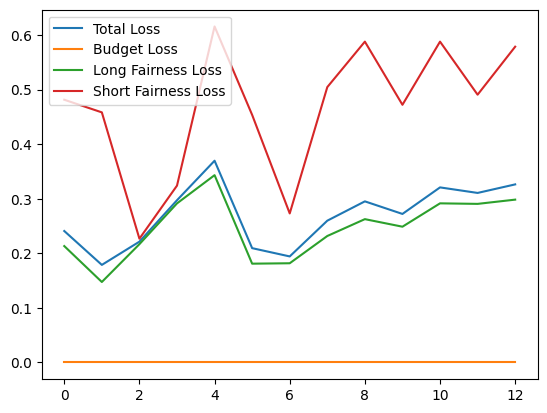

Epoch:    0 | Total Loss:   0.0810 | Budget Loss:  0.00 | Long Fairness Loss:  0.0759 | Improvement Loss:  0.6259 | Time:  42.0 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 2
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Epoch:   10 | Total Loss:   0.0698 | Budget Loss:  0.00 | Long Fairness Loss:  0.0658 | Improvement Loss:  0.6655 | Time:  43.1 | Patience: 6
Checkpoint saved at epoch 11
Checkpoint saved at epoch 15
Epoch:   20 | Total Loss:   0.0652 | Budget Loss:  0.00 | Long Fairness Loss:  0.0601 | Improvement Loss:  0.6735 | Time:  42.3 | Patience: 5
Early stopping
 Last save: 15
Last saved epoch:  15


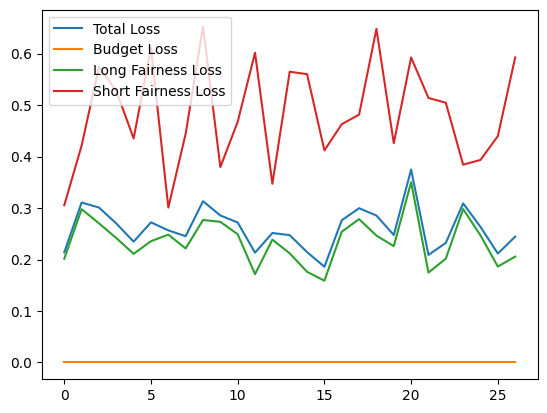

Epoch:    0 | Total Loss:   0.0780 | Budget Loss:  0.00 | Long Fairness Loss:  0.0697 | Improvement Loss:  0.6168 | Time:  43.7 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 4
Epoch:   10 | Total Loss:   0.0883 | Budget Loss:  0.00 | Long Fairness Loss:  0.0805 | Improvement Loss:  0.6689 | Time:  42.9 | Patience: 6
Checkpoint saved at epoch 11
Checkpoint saved at epoch 18
Epoch:   20 | Total Loss:   0.0802 | Budget Loss:  0.00 | Long Fairness Loss:  0.0758 | Improvement Loss:  0.6463 | Time:  43.2 | Patience: 2
Checkpoint saved at epoch 25
Epoch:   30 | Total Loss:   0.0891 | Budget Loss:  0.00 | Long Fairness Loss:  0.0804 | Improvement Loss:  0.6429 | Time:  43.2 | Patience: 5
Early stopping
 Last save: 25
Last saved epoch:  25


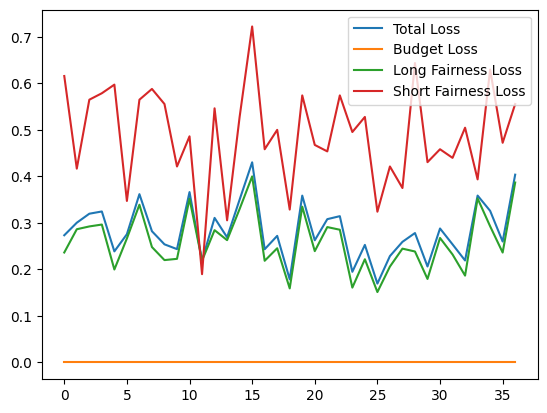

Epoch:    0 | Total Loss:   0.0781 | Budget Loss:  0.00 | Long Fairness Loss:  0.0759 | Improvement Loss:  0.6395 | Time:  41.6 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 3
Epoch:   10 | Total Loss:   0.0876 | Budget Loss:  0.00 | Long Fairness Loss:  0.0820 | Improvement Loss:  0.6440 | Time:  42.5 | Patience: 7
Early stopping
 Last save: 3
Last saved epoch:  3


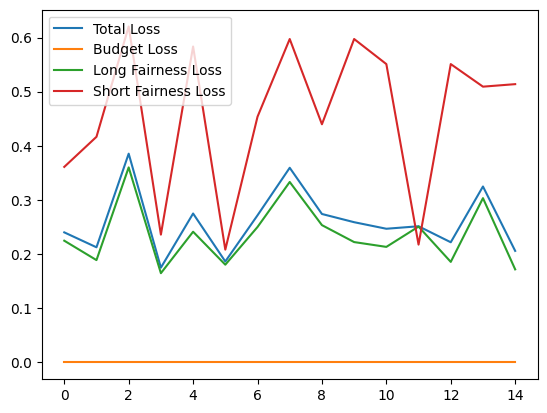

In [ ]:
import time
original_data = data_module.total_dataloader().dataset.X
t0 = original_pairs[:int(n*0.7), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device, dataset='toy')
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
loss_fn = torch.nn.MSELoss()
net = effortLSTM(data_module, loader, seq_len, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [0.5, 1, 2, 4]
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
    df.to_csv('steps.csv')
    data_module = vaca_dataset(1, t0, device, dataset='toy')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortLSTM(data_module, loader, seq_len, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    efforts_path = log_dir / (f"LSTM_effort_model_2layers" + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_v2.pth")
    checkpoint_path = log_dir / (f"LSTM_effort_model_2layers" + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_checkpoint_v2.pth")
    best_loss = float('inf')
    patience = 0
    last_epoch=0

    hist_loss = []
    buget_loss = []
    hist_lt_loss = []
    hist_st_loss = []
    lt_w = 10
    st_w = 1
    imp_w = 0.1
    t_weight = imp_w + lt_w + st_w
    for epoch in range(last_epoch, 100):
        epoch_start = time.time()
        net.train()
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        #efforts.requires_grad = True
        efforts.retain_grad()
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts.view(len(loader), seq_len-1, 2), seq_len, 'toy', device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
        lt_fairness = compute_distance_loss(data)
        st_fairness = compute_st_loss(s, y_hat)
        t_loss = 1000*budget_penalty(efforts, budget*0.98) + (imp_w*improvement_loss +
                  lt_w*lt_fairness + 
                  st_w*st_fairness)/t_weight
        t_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        
        optimizer.step()
        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            df = pd.DataFrame(original_data)
            df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
            df.to_csv('steps.csv')
            data_module = vaca_dataset(1, t0, device, 'toy')
            val_loader = data_module.val_dataloader()
            data_module.batch_size = 1
            val_s = tensor(val_loader.dataset.X[:,0]).view(len(val_loader.dataset), 1).to(device)
            val_loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
            val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
            val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'toy', device)
            val_loss = 1000*budget_penalty(val_efforts, budget*0.98) + (imp_w*loss_fn(val_y, torch.ones_like(val_y)) + lt_w*compute_distance_loss(val_data) + st_w*compute_st_loss(val_s, val_y))/t_weight

        if epoch < 5:
            warmup_lr = 0.0001 * (epoch + 1) / 5
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
        else:
            scheduler.step(val_loss.item())
        
        df = pd.DataFrame(original_data)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        epoch_end = time.time()
        hist_loss.append(val_loss.item())
        buget_loss.append(1000*budget_penalty(val_efforts, budget*0.98).item())
        hist_lt_loss.append(compute_distance_loss(val_data).item())
        hist_st_loss.append(compute_st_loss(val_s, val_y).item())

        if (val_loss < best_loss and epoch > 0):
            best_loss = val_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            save_checkpoint(epoch, net, optimizer, best_loss, checkpoint_path)
            e = epoch
            
        
        else:
            patience += 1
            if (patience > 10 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}')

    print('Last saved epoch: ', e)

    plt.legend()
    plt.show()


In [ ]:
import time
original_data = data_module.total_dataloader().dataset.X
t0 = original_pairs[:int(n*0.7), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device, dataset='toy')
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
loss_fn = torch.nn.MSELoss()
net = effortNN(data_module, loader, seq_len, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [0.5, 1, 2, 4]
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
    df.to_csv('steps.csv')
    data_module = vaca_dataset(1, t0, device, dataset='toy')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortNN(data_module, loader, seq_len, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    efforts_path = log_dir / (f"NN_effort_model_2layers" + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_v2.pth")
    checkpoint_path = log_dir / (f"NN_effort_model_2layers" + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_checkpoint_v2.pth")
    best_loss = float('inf')
    patience = 0
    last_epoch=0

    hist_loss = []
    buget_loss = []
    hist_lt_loss = []
    hist_st_loss = []
    lt_w = 10
    st_w = 1
    imp_w = 0.1
    t_weight = imp_w + lt_w + st_w
    for epoch in range(last_epoch, 100):
        epoch_start = time.time()
        net.train()
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        #efforts.requires_grad = True
        efforts.retain_grad()
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts.view(len(loader), seq_len-1, 2), seq_len, 'toy', device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
        lt_fairness = compute_distance_loss(data)
        st_fairness = compute_st_loss(s, y_hat)
        t_loss = 1000*budget_penalty(efforts, budget*0.98) + (imp_w*improvement_loss +
                  lt_w*lt_fairness + 
                  st_w*st_fairness)/t_weight
        t_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        
        optimizer.step()
        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            df = pd.DataFrame(original_data)
            df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
            df.to_csv('steps.csv')
            data_module = vaca_dataset(1, t0, device, 'toy')
            val_loader = data_module.val_dataloader()
            data_module.batch_size = 1
            val_s = tensor(val_loader.dataset.X[:,0]).view(len(val_loader.dataset), 1).to(device)
            val_loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
            val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
            val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'toy', device)
            val_loss = 1000*budget_penalty(val_efforts, budget*0.98) + (imp_w*loss_fn(val_y, torch.ones_like(val_y)) + lt_w*compute_distance_loss(val_data) + st_w*compute_st_loss(val_s, val_y))/t_weight

        if epoch < 5:
            warmup_lr = 0.0001 * (epoch + 1) / 5
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
        else:
            scheduler.step(val_loss.item())
        
        df = pd.DataFrame(original_data)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        epoch_end = time.time()
        hist_loss.append(val_loss.item())
        buget_loss.append(1000*budget_penalty(val_efforts, budget*0.98).item())
        hist_lt_loss.append(compute_distance_loss(val_data).item())
        hist_st_loss.append(compute_st_loss(val_s, val_y).item())

        if (val_loss < best_loss and epoch > 0):
            best_loss = val_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            save_checkpoint(epoch, net, optimizer, best_loss, checkpoint_path)
            e = epoch
            
        
        else:
            patience += 1
            if (patience > 10 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}')

    print('Last saved epoch: ', e)

    plt.legend()
    plt.show()


## Testing

In [ ]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
short_term_og = np.empty((len(seeds), seq_len))
loader = data_module.total_dataloader()
b_list = [0.5, 1, 2, 4]
n = 200
for _b in b_list:
    net = effortNN(data_module, loader, seq_len, device)
    model_fairness_lstm_clf = np.empty((len(seeds), seq_len))
    short_term_fairness_clf = np.empty((len(seeds), seq_len))
    budget = _b*seq_len
    efforts_lstm_clf = torch.empty(len(seeds), n, seq_len-1, 2)
    efforts_path = log_dir / (f"NN_effort_model_2layers" + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + ".pth")
    checkpoint = torch.load(efforts_path, map_location=device)
    try:
        net.load_state_dict(checkpoint)
    except RuntimeError as e:
        print("Error loading state_dict:", e)
    for seed in seeds:
        t1 = time.time()
        s0, x0, y0 = gen_gaussian(n, seed=seed)
        x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, seed=seed)
        gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
        p_to_csv(s0.reshape(n,1), x[:, 0:2, :], y[:, 0:2, :], 'toy')
        for i in range(seq_len):
            gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
            short_loss = compute_st_loss(s0, y_gan[:, i, :])
            distance = compute_distance_loss(gan_output.to(device))
            short_term_og[seed-2031, i] = short_loss.item()
            og_fairness[seed-2031, i] = distance.item()
        data_module = vaca_dataset(1, y, device, 'toy')
        loader = data_module.total_dataloader()
        loader.dataset.set_intervention({'x1': 0, 'z1': 0}, is_noise=True)
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, 7).to(device))
        efforts_lstm_clf[seed-2031] = efforts.view(n, seq_len-1, 2).detach().cpu()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
        for i in range(seq_len-1):
            data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
            st_fairness = compute_st_loss(data[:, 0].view(n,1).to(device), y_hat[:,i].view(n,1).to(device))
            short_term_fairness_clf[seed-2031, i+1] = st_fairness.item()
            distance = compute_distance_loss(data_t)
            model_fairness_lstm_clf[seed-2031, i+1] = distance.item()

        t2 = time.time()
        print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
        np.save('nn_efforts_budget_toy_' + str(budget) + '.npy', efforts_lstm_clf)
        np.save('lt_fairness_nn_budget_toy_'+str(budget)+'.npy', model_fairness_lstm_clf)
        np.save('st_fairness_nn_budget_toy_'+str(budget)+'.npy', short_term_fairness_clf)
    np.save('st_fairness_og_toy.npy', short_term_og)
    np.save('og_fairness_toy.npy', og_fairness)

Seed: 2031 | Time:  54.85
Seed: 2032 | Time:  55.23
Seed: 2033 | Time:  55.10
Seed: 2034 | Time:  54.25
Seed: 2035 | Time:  55.47
Seed: 2036 | Time:  54.33
Seed: 2037 | Time:  52.88
Seed: 2038 | Time:  55.03
Seed: 2039 | Time:  56.69
Seed: 2040 | Time:  53.26
Seed: 2041 | Time:  54.63
Seed: 2042 | Time:  53.64
Seed: 2043 | Time:  55.18
Seed: 2044 | Time:  53.84
Seed: 2045 | Time:  54.94
Seed: 2046 | Time:  54.79
Seed: 2047 | Time:  56.15
Seed: 2048 | Time:  54.04
Seed: 2049 | Time:  55.15
Seed: 2050 | Time:  55.24
Seed: 2051 | Time:  54.76
Seed: 2052 | Time:  53.55
Seed: 2053 | Time:  55.07
Seed: 2054 | Time:  54.54
Seed: 2055 | Time:  54.96
Seed: 2056 | Time:  54.68
Seed: 2057 | Time:  56.01
Seed: 2058 | Time:  55.10
Seed: 2059 | Time:  54.68
Seed: 2060 | Time:  55.39


In [ ]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
short_term_fairness_og = np.empty((len(seeds), seq_len))
loss_fn = torch.nn.MSELoss(reduction='mean')
for _b in [0.5, 1, 2, 4]:
    model_fairness_lstm = np.empty((len(seeds), seq_len))
    loader = data_module.total_dataloader()
    net = effortLSTM(data_module, loader, seq_len, device)
    n = 200
    budget = _b*seq_len
    efforts_lstm = torch.empty(len(seeds), n, seq_len-1, 2)
    efforts_path = log_dir / (f"LSTM_effort_model_2layers" + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_v2.pth")
    checkpoint = torch.load(efforts_path, map_location=device)
    try:
        net.load_state_dict(checkpoint)
    except RuntimeError as e:
        print("Error loading state_dict:", e)
    short_term_fairness_lstm = np.empty((len(seeds), seq_len))
    model_accuracy = np.empty((len(seeds), seq_len))
    failed_flag = False
    for seed in seeds:
        t1 = time.time()
        s0, x0, y0 = gen_gaussian(n,e=epsilon, seed=seed)
        x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=epsilon, noise_factor=0.1, seed=seed)
        gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
        p_to_csv(s0.reshape(n,1), x[:, 0:2, :], y[:, 0:2, :], 'toy')
        for i in range(seq_len):
            gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
            short_loss = compute_st_loss(s0, y_gan[:, i, :])
            distance = compute_distance_loss(gan_output.to(device))
            og_fairness[seed-2031, i] = distance.item()
            short_term_fairness_og[seed-2031, i] = short_loss.item()
        data_module = vaca_dataset(1, y, device, 'toy')
        loader = data_module.total_dataloader()
        loader.dataset.set_intervention({'x1': 0, 'z1': 0}, is_noise=True)
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, 7).to(device))
        efforts_lstm[seed-2031] = efforts.view(n, seq_len-1, 2).detach().cpu()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
        gt_y = torch.bernoulli((1 /(1+  torch.exp(-(x_hat[:,0,0]+3*x_hat[:,0,1]-1))))).view(n, 1)
        lstm_accuracy = loss_fn(gt_y, y_hat[:,0].view(n,1).to(device))
        model_accuracy[seed-2031, 0] = lstm_accuracy.item()
        for i in range(seq_len-1):
            data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
            gt_y = torch.bernoulli((1 /(1+  torch.exp(-(x_hat[:,i,0]+3*x_hat[:,i,1]-1))))).view(n, 1)
            lstm_accuracy = loss_fn(gt_y, y_hat[:,i].view(n,1).to(device))
            model_accuracy[seed-2031, i+1] = lstm_accuracy.item()
            st_fairness = compute_st_loss(data[:, 0].view(n,1).to(device), y_hat[:,i].view(n,1).to(device))
            short_term_fairness_lstm[seed-2031, i+1] = st_fairness.item()
            distance = compute_distance_loss(data_t)
            model_fairness_lstm[seed-2031, i+1] = distance.item()

        t2 = time.time()
        print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    np.save('lstm_accuracy_budget_toy_' + str(budget) + '.npy', model_accuracy)
    np.save('efforts_budget_lstm_toy_' + str(budget) + '.npy', efforts_lstm)
    np.save(f'lt_fairness_budget_toy_{budget}.npy', model_fairness_lstm)
    np.save(f'st_fairness_budget_toy_{budget}.npy', short_term_fairness_lstm)
    

Seed: 2031 | Time:  45.73
Seed: 2032 | Time:  43.96
Seed: 2033 | Time:  46.33
Seed: 2034 | Time:  48.67
Seed: 2035 | Time:  48.48
Seed: 2036 | Time:  49.79
Seed: 2037 | Time:  49.55
Seed: 2038 | Time:  50.65
Seed: 2039 | Time:  49.44
Seed: 2040 | Time:  49.26
Seed: 2041 | Time:  49.61
Seed: 2042 | Time:  47.25
Seed: 2043 | Time:  50.63
Seed: 2044 | Time:  48.81
Seed: 2045 | Time:  49.17
Seed: 2046 | Time:  50.33
Seed: 2047 | Time:  49.58
Seed: 2048 | Time:  49.89
Seed: 2049 | Time:  48.31
Seed: 2050 | Time:  50.28
Seed: 2051 | Time:  48.79
Seed: 2052 | Time:  49.35
Seed: 2053 | Time:  49.77
Seed: 2054 | Time:  49.89
Seed: 2055 | Time:  48.69
Seed: 2056 | Time:  49.69
Seed: 2057 | Time:  50.71
Seed: 2058 | Time:  49.93
Seed: 2059 | Time:  49.24
Seed: 2060 | Time:  50.06
Seed: 2031 | Time:  49.94
Seed: 2032 | Time:  49.33
Seed: 2033 | Time:  50.01
Seed: 2034 | Time:  49.96
Seed: 2035 | Time:  49.70
Seed: 2036 | Time:  50.32
Seed: 2037 | Time:  48.38
Seed: 2038 | Time:  49.46
Seed: 2039 |

## Baseline WIP

In [39]:
from baseline import *

s0, x0, y0 = gen_gaussian(n,e=epsilon, seed=52)
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=epsilon, noise_factor=0.1, b=b, seed=52)
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

train_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)[0:int(n*(1-test_size)), :]
test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)[int(n*(1-test_size)):, :]

train_dataset = SimpleDataset(train_data[:, :-1], train_data[:, -1])
test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/baseline.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(self.features[idx], dtype=torch.float32)
/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/baseline.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32)


Epoch 0 p_loss: 1.2732329219579697, f_loss: 2.611461639404297
Epoch 10 p_loss: 0.36120370030403137, f_loss: 0.3972330093383789
Epoch 20 p_loss: 0.27531072683632374, f_loss: 1.5921802520751953
Epoch 30 p_loss: 0.24539639055728912, f_loss: 0.8005237579345703
Epoch 40 p_loss: 0.23015224188566208, f_loss: 3.1706924438476562


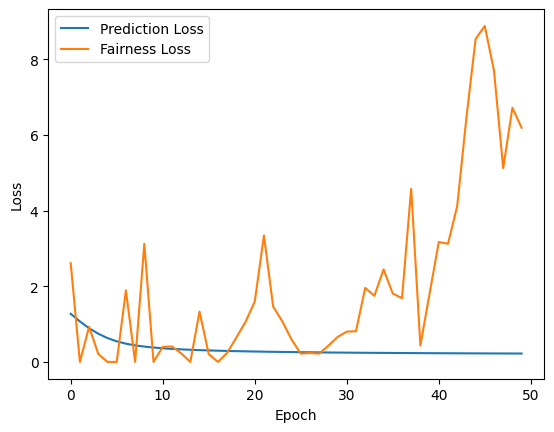

In [52]:
ei_model = trainer_fb_fair(model, train_loader, [1,2], optim, device, 50, 0.5)

Epoch 0 | p_loss: 0.7849, f_loss: 21.0457
Epoch 10 | p_loss: 0.5444, f_loss: 45.8614
Epoch 20 | p_loss: 0.4373, f_loss: 52.3155
Epoch 30 | p_loss: 0.3705, f_loss: 54.9890
Epoch 40 | p_loss: 0.3292, f_loss: 56.4206


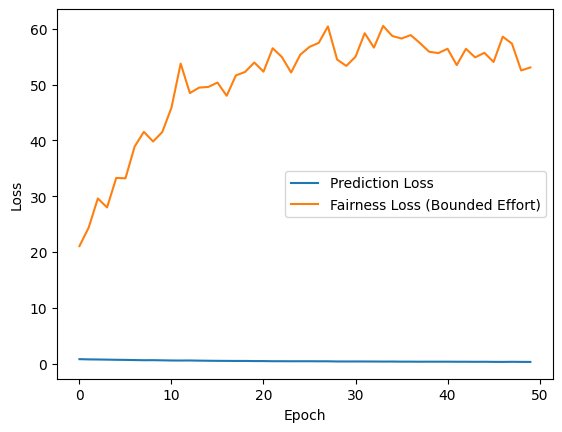

In [55]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
be_model = trainer_bounded_effort(model, train_loader, [1,2], optim, device, 50, 0.5)

Epoch 0 | p_loss: 0.8324, ILER loss: 0.0002
PGD effort norms: 0.015529590658843517
Mean effort for group 0: tensor(0.0156, device='cuda:0', grad_fn=<MeanBackward0>)
Mean effort for group 1: tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 10 | p_loss: 0.5971, ILER loss: 0.0028
PGD effort norms: 0.017458630725741386
Mean effort for group 0: tensor(0.0168, device='cuda:0', grad_fn=<MeanBackward0>)
Mean effort for group 1: tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 20 | p_loss: 0.4762, ILER loss: 0.0057
PGD effort norms: 0.018862806260585785
Mean effort for group 0: tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>)
Mean effort for group 1: tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 30 | p_loss: 0.3949, ILER loss: 0.0066
PGD effort norms: 0.019620414823293686
Mean effort for group 0: tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>)
Mean effort for group 1: tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 40 

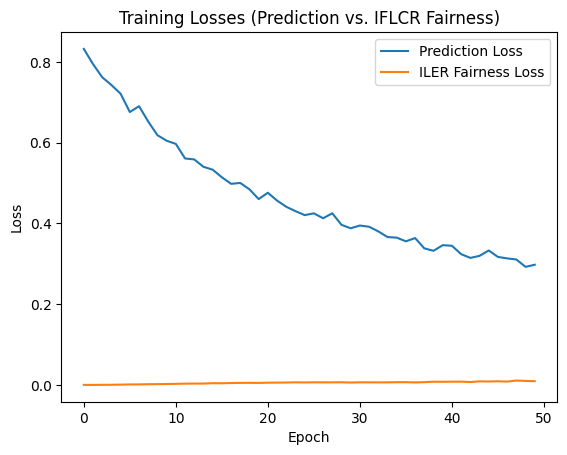

In [56]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
iler_model = trainer_iler(model, train_loader, [1,2], optim, device, 50, 0.5)

In [ ]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
er_model = trainer_er(model, train_loader, [1,2], optim, device, 50, 0.5)

Epoch 0 | p_loss: 0.8640, ER fairness loss: 0.0128
PGD effort norms: 0.019705455750226974
Mean effort for group 0: tensor(0.2012, device='cuda:0', grad_fn=<MulBackward0>)
Mean effort for group 1: tensor(0.1908, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 10 | p_loss: 0.5600, ER fairness loss: 0.0209
PGD effort norms: 0.016071008518338203
Mean effort for group 0: tensor(0.1546, device='cuda:0', grad_fn=<MulBackward0>)
Mean effort for group 1: tensor(0.1775, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 20 | p_loss: 0.4063, ER fairness loss: 0.0460
PGD effort norms: 0.01761663891375065
Mean effort for group 0: tensor(0.1666, device='cuda:0', grad_fn=<MulBackward0>)
Mean effort for group 1: tensor(0.2167, device='cuda:0', grad_fn=<MulBackward0>)


/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/baseline.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(self.features[idx], dtype=torch.float32)
/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/baseline.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32)


Epoch 0 p_loss: 1.3606065064668655, f_loss: 0.18361279368400574
Epoch 10 p_loss: 0.5551368370652199, f_loss: 0.1103268414735794
Epoch 20 p_loss: 0.5057429745793343, f_loss: 0.04471713677048683
Epoch 30 p_loss: 0.44595126807689667, f_loss: 0.058621957898139954
Epoch 40 p_loss: 0.41554737091064453, f_loss: 0.06180231273174286


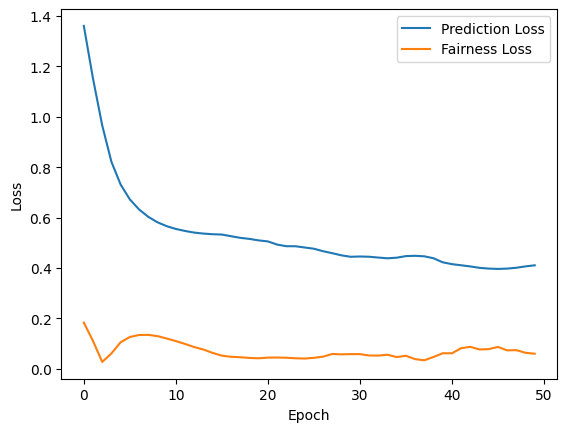

In [40]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
dp_model = trainer_dp_fair(model, train_loader, optim, device, 50, 0.5)

In [ ]:
seeds = list(range(2031, 2061))
n = 200
EI_fairness = np.empty((len(seeds), seq_len))
efforts_baseline = []
data = np.empty((n, seq_len, x_dim + 2))
loss_fn = torch.nn.MSELoss()
EI_accuracy = np.empty((len(seeds), seq_len))
EI_short_term = np.empty((len(seeds), seq_len))
b_list = [0.5, 1, 2, 4]
for _b in b_list:
    budget = _b*seq_len

    for seed in seeds:
        s0, x0, y0 = gen_gaussian(n, e=epsilon, seed=seed)
        test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
        test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        torch.manual_seed(seed)
        z_mb = torch.randn(len(s0), 1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        distance = compute_distance_loss(test_data.to(device))
        EI_fairness[seed-2031, 0] = distance.item()    
        _y = ei_model.predict(s0, x0)
        gt_y = clf.predict(s0, x0)
        gt_y = tensor(gt_y).to(device)
        EI_accuracy[seed-2031, 0] = loss_fn(_y, gt_y.to(device)).item()
        EI_short_term[seed-2031, 0] = compute_st_loss(s0, gt_y).item()
        x_gan, _, y_gan = generator(x0, z_mb, s0, ei_model.to(device))
        p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
        datamodule = vaca_dataset(1, y0, device, 'toy')
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
        test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        new_budget = tensor([_b])
        for i in range(1, seq_len):
            _, e, _data = test_fb_fair(ei_model, test_loader, [1,2], device=device, delta_effort=new_budget.item())
            effort_indices = ((test_loader.dataset.labels < 1).squeeze()).nonzero()
            efforts = torch.zeros([len(test_loader.dataset), int((x_dim)*2+3)]).to(device)
            efforts[effort_indices[0], x_dim+2:x_dim+4] = e[:, [1, 2]].to(device)
            x_gan_input = intervention_step(loader, model_vaca, datamodule.test_dataset.nodes_to_intervene, efforts, datamodule.test_dataset.nodes_list, device)
            x_gan_input = x_gan_input.to(device)
            _s = torch.tensor(test_loader.dataset.features[:, 0]).to(device)
            _y = ei_model.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = clf.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = tensor(gt_y).to(device)
            
            distance = compute_distance_loss(torch.cat([_s.unsqueeze(1), x_gan_input.squeeze(), _y], dim=1).to(device))
            EI_fairness[seed-2031, i] = distance.item()
            new_budget = _b+(_b+torch.mean(torch.sum(torch.abs(e), dim=1)))
            data[:, i, 1:-1] = x_gan_input.squeeze().detach().cpu().numpy()
            data[:, i, 0] = _s.detach().cpu().numpy()
            data[:, i, -1] = gt_y.squeeze().detach().cpu().numpy()
            acc = loss_fn(_y, gt_y.to(device))
            EI_accuracy[seed-2031, i] = acc.item()
            EI_short_term[seed-2031, i] = compute_st_loss(_s, _y).item()
            z_mb = torch.randn(len(_s), 1, x_dim).to(device)
            x_gan, _, y_gan = generator(x_gan_input.squeeze().to(device), z_mb, _s.unsqueeze(1), ei_model.to(device))
            p_to_csv(_s.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
            datamodule = vaca_dataset(1, y0, device, 'toy')
            loader = datamodule.total_dataloader()
            loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
            test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
            test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
            efforts_baseline.append(e[:, [1, 2]])
    np.save(f'ei_fairness_toy_budget_{budget}.npy', EI_fairness)
    np.save(f'ei_accuracy_toy_budget__{budget}.npy', EI_accuracy)
    np.save(f'ei_short_term_toy_budget_{budget}.npy', EI_short_term)

In [45]:
seeds = list(range(2031, 2061))
n = 200
BE_fairness = np.empty((len(seeds), seq_len))
be_efforts_baseline = []
data = np.empty((n, seq_len, x_dim + 2))
loss_fn = torch.nn.MSELoss()
BE_accuracy = np.empty((len(seeds), seq_len))
BE_short_term = np.empty((len(seeds), seq_len))
for _b in [0.5, 1, 2, 4]:
    budget = _b*seq_len

    for seed in seeds:
        s0, x0, y0 = gen_gaussian(n, seed=seed)
        test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
        test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        torch.manual_seed(seed)
        z_mb = torch.randn(len(s0), 1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        distance = compute_distance_loss(test_data.to(device))
        BE_fairness[seed-2031, 0] = distance.item()    
        _y = be_model.predict(s0, x0)
        gt_y = clf.predict(s0, x0)
        gt_y = tensor(gt_y).to(device)
        BE_accuracy[seed-2031, 0] = loss_fn(_y, gt_y.to(device)).item()
        BE_short_term[seed-2031, 0] = compute_st_loss(s0, gt_y).item()
        x_gan, _, y_gan = generator(x0, z_mb, s0, be_model.to(device))
        p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
        datamodule = vaca_dataset(1, y0, device, 'toy')
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
        test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        new_budget = tensor([_b])
        for i in range(1, seq_len):
            _, e, _data = test_bounded_effort(be_model, test_loader, [1,2], device=device, delta_effort=new_budget.item())
            effort_indices = ((test_loader.dataset.labels < 1).squeeze()).nonzero()
            efforts = torch.zeros([len(test_loader.dataset), int((x_dim)*2+3)]).to(device)
            efforts[effort_indices[0], x_dim+2:x_dim+4] = e[:, [1, 2]].to(device)
            x_gan_input = intervention_step(loader, model_vaca, datamodule.test_dataset.nodes_to_intervene, efforts, datamodule.test_dataset.nodes_list, device)
            x_gan_input = x_gan_input.to(device)
            _s = torch.tensor(test_loader.dataset.features[:, 0]).to(device)
            _y = be_model.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = clf.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = tensor(gt_y).to(device)
            
            distance = compute_distance_loss(torch.cat([_s.unsqueeze(1), x_gan_input.squeeze(), _y], dim=1).to(device))
            BE_fairness[seed-2031, i] = distance.item()
            new_budget = _b+(_b+torch.mean(torch.sum(torch.abs(e), dim=1)))
            data[:, i, 1:-1] = x_gan_input.squeeze().detach().cpu().numpy()
            data[:, i, 0] = _s.detach().cpu().numpy()
            data[:, i, -1] = gt_y.squeeze().detach().cpu().numpy()
            acc = loss_fn(_y, gt_y.to(device))
            BE_accuracy[seed-2031, i] = acc.item()
            BE_short_term[seed-2031, i] = compute_st_loss(_s, _y).item()
            z_mb = torch.randn(len(_s), 1, x_dim).to(device)
            x_gan, _, y_gan = generator(x_gan_input.squeeze().to(device), z_mb, _s.unsqueeze(1), be_model.to(device))
            p_to_csv(_s.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
            datamodule = vaca_dataset(1, y0, device, 'toy')
            loader = datamodule.total_dataloader()
            loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
            test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
            test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
            be_efforts_baseline.append(e[:, [1, 2]])
    np.save(f'be_fairness_toy_budget_{budget}.npy', BE_fairness)
    np.save(f'be_accuracy_toy_budget__{budget}.npy', BE_accuracy)
    np.save(f'be_short_term_toy_budget_{budget}.npy', BE_short_term)

NameError: name 'be_model' is not defined

In [ ]:
seeds = list(range(2031, 2061))
n = 200
ER_fairness = np.empty((len(seeds), seq_len))
efforts_baseline = []
data = np.empty((n, seq_len, x_dim + 2))
loss_fn = torch.nn.MSELoss()
ER_accuracy = np.empty((len(seeds), seq_len))
ER_short_term = np.empty((len(seeds), seq_len))
b = 0.5
b_list = [0.5, 1, 2, 4]
for _b in b_list:
    budget = _b*seq_len

    for seed in seeds:
        s0, x0, y0 = gen_gaussian(n, seed=seed)
        test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
        test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        torch.manual_seed(seed)
        z_mb = torch.randn(len(s0), 1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        distance = compute_distance_loss(test_data.to(device))
        ER_fairness[seed-2031, 0] = distance.item()    
        _y = er_model.predict(s0, x0)
        gt_y = clf.predict(s0, x0)
        gt_y = tensor(gt_y).to(device)
        ER_accuracy[seed-2031, 0] = loss_fn(_y, gt_y.to(device)).item()
        ER_short_term[seed-2031, 0] = compute_st_loss(s0, gt_y).item()
        x_gan, _, y_gan = generator(x0, z_mb, s0, er_model.to(device))
        p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
        datamodule = vaca_dataset(1, y0, device, 'toy')
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
        test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        new_budget = tensor([_b])
        for i in range(1, seq_len):
            _, e, _data, _ = test_er(er_model, test_loader, [1,2], device=device, delta_effort=new_budget.item())
            effort_indices = ((test_loader.dataset.labels < 1).squeeze()).nonzero()
            efforts = torch.zeros([len(test_loader.dataset), int((x_dim)*2+3)]).to(device)
            efforts[effort_indices[0], x_dim+2:x_dim+4] = e[:, [1, 2]].to(device)
            x_gan_input = intervention_step(loader, model_vaca, datamodule.test_dataset.nodes_to_intervene, efforts, datamodule.test_dataset.nodes_list, device)
            x_gan_input = x_gan_input.to(device)
            _s = torch.tensor(test_loader.dataset.features[:, 0]).to(device)
            _y = er_model.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = clf.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = tensor(gt_y).to(device)
            
            distance = compute_distance_loss(torch.cat([_s.unsqueeze(1), x_gan_input.squeeze(), _y], dim=1).to(device))
            ER_fairness[seed-2031, i] = distance.item()
            new_budget = _b+(_b+torch.mean(torch.sum(torch.abs(e), dim=1)))
            data[:, i, 1:-1] = x_gan_input.squeeze().detach().cpu().numpy()
            data[:, i, 0] = _s.detach().cpu().numpy()
            data[:, i, -1] = gt_y.squeeze().detach().cpu().numpy()
            acc = loss_fn(_y, gt_y.to(device))
            ER_accuracy[seed-2031, i] = acc.item()
            ER_short_term[seed-2031, i] = compute_st_loss(_s, _y).item()
            z_mb = torch.randn(len(_s), 1, x_dim).to(device)
            x_gan, _, y_gan = generator(x_gan_input.squeeze().to(device), z_mb, _s.unsqueeze(1), er_model.to(device))
            p_to_csv(_s.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
            datamodule = vaca_dataset(1, y0, device, 'toy')
            loader = datamodule.total_dataloader()
            loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
            test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
            test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
            efforts_baseline.append(e[:, [1, 2]])
    np.save(f'er_fairness_toy_budget_{budget}.npy', ER_fairness)
    np.save(f'er_accuracy_toy_budget__{budget}.npy', ER_accuracy)
    np.save(f'er_short_term_toy_budget_{budget}.npy', ER_short_term)

In [ ]:
seeds = list(range(2031, 2061))
n = 200
ILER_fairness = np.empty((len(seeds), seq_len))
efforts_baseline = []
data = np.empty((n, seq_len, x_dim + 2))
loss_fn = torch.nn.MSELoss()
ILER_accuracy = np.empty((len(seeds), seq_len))
ILER_short_term = np.empty((len(seeds), seq_len))
b_list = [0.5, 1, 2, 4]
for _b in b_list:
    budget = _b*seq_len

    for seed in seeds:
        s0, x0, y0 = gen_gaussian(n, seed=seed)
        test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
        test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        torch.manual_seed(seed)
        z_mb = torch.randn(len(s0), 1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        distance = compute_distance_loss(test_data.to(device))
        ILER_fairness[seed-2031, 0] = distance.item()    
        _y = iler_model.predict(s0, x0)
        gt_y = clf.predict(s0, x0)
        gt_y = tensor(gt_y).to(device)
        ILER_accuracy[seed-2031, 0] = loss_fn(_y, gt_y.to(device)).item()
        ILER_short_term[seed-2031, 0] = compute_st_loss(s0, gt_y).item()
        x_gan, _, y_gan = generator(x0, z_mb, s0, iler_model.to(device))
        p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
        datamodule = vaca_dataset(1, y0, device, 'toy')
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
        test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        new_budget = tensor([_b])
        for i in range(1, seq_len):
            _, e, _data, _ = test_iler(iler_model, test_loader, [1,2], device=device, delta_effort=new_budget.item())
            effort_indices = ((test_loader.dataset.labels < 1).squeeze()).nonzero()
            efforts = torch.zeros([len(test_loader.dataset), int((x_dim)*2+3)]).to(device)
            efforts[effort_indices[0], x_dim+2:x_dim+4] = e[:, [1, 2]].to(device)
            x_gan_input = intervention_step(loader, model_vaca, datamodule.test_dataset.nodes_to_intervene, efforts, datamodule.test_dataset.nodes_list, device)
            x_gan_input = x_gan_input.to(device)
            _s = torch.tensor(test_loader.dataset.features[:, 0]).to(device)
            _y = iler_model.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = clf.predict(_s.unsqueeze(1), x_gan_input.squeeze())
            gt_y = tensor(gt_y).to(device)
            
            distance = compute_distance_loss(torch.cat([_s.unsqueeze(1), x_gan_input.squeeze(), _y], dim=1).to(device))
            ILER_fairness[seed-2031, i] = distance.item()
            new_budget = _b+(_b+torch.mean(torch.sum(torch.abs(e), dim=1)))
            data[:, i, 1:-1] = x_gan_input.squeeze().detach().cpu().numpy()
            data[:, i, 0] = _s.detach().cpu().numpy()
            data[:, i, -1] = gt_y.squeeze().detach().cpu().numpy()
            acc = loss_fn(_y, gt_y.to(device))
            ILER_accuracy[seed-2031, i] = acc.item()
            ILER_short_term[seed-2031, i] = compute_st_loss(_s, _y).item()
            z_mb = torch.randn(len(_s), 1, x_dim).to(device)
            x_gan, _, y_gan = generator(x_gan_input.squeeze().to(device), z_mb, _s.unsqueeze(1), iler_model.to(device))
            p_to_csv(_s.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'toy')
            datamodule = vaca_dataset(1, y0, device, 'toy')
            loader = datamodule.total_dataloader()
            loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
            test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
            test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
            efforts_baseline.append(e[:, [1, 2]])
    np.save(f'iler_fairness_toy_budget_{budget}.npy', ILER_fairness)
    np.save(f'iler_accuracy_toy_budget__{budget}.npy', ILER_accuracy)
    np.save(f'iler_short_term_toy_budget_{budget}.npy', ILER_short_term)

In [41]:
seeds = list(range(2031, 2061))
n = 200
DP_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))
DP_short_term = np.empty((len(seeds), seq_len))

for seed in seeds:
    s0, x0, y0 = gen_gaussian(n, seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([2])
    for i in range(seq_len):
        _, _data = test_dp_fair(dp_model, test_loader, device)
        #new_budget = 2+(2-torch.mean(torch.sum(torch.abs(e), dim=1)))
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, torch.tensor(s0, dtype=torch.float32).view(n, 1).to(device), dp_model.to(device))
        gt_y = clf(_s.to(device), _x.to(device))
        short_loss = compute_st_loss(_s.to(device), gt_y)
        DP_short_term[seed-2031, i] = short_loss.item()
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([torch.tensor(s0, dtype=torch.float32).view(n, 1).to(device), gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([torch.tensor(s0, dtype=torch.float32).view(n, 1).to(device), gan_x, gan_y], dim=1).to(device))
        DP_fairness[seed-2031, i] = distance.item()
        data[:, i, :] = torch.cat([torch.tensor(s0, dtype=torch.float32).view(n, 1).to(device), gan_x, gan_y], dim=1).detach().cpu().numpy()

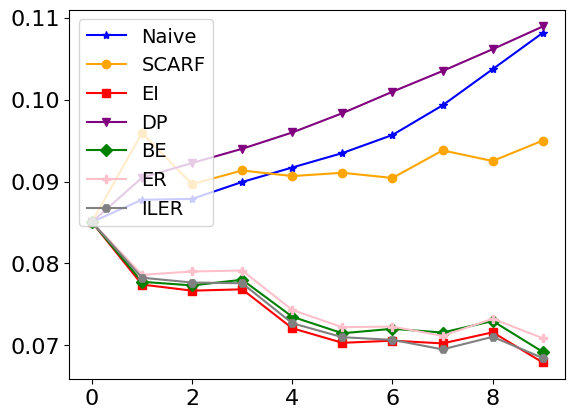

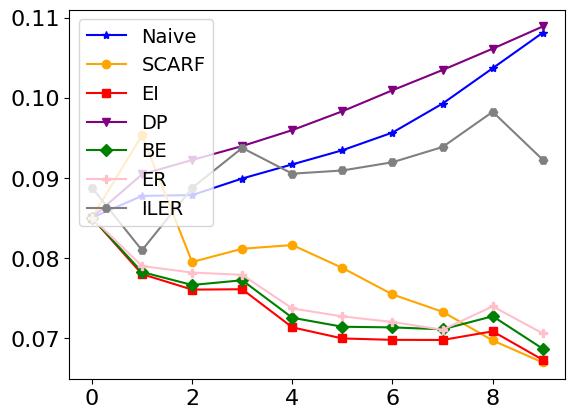

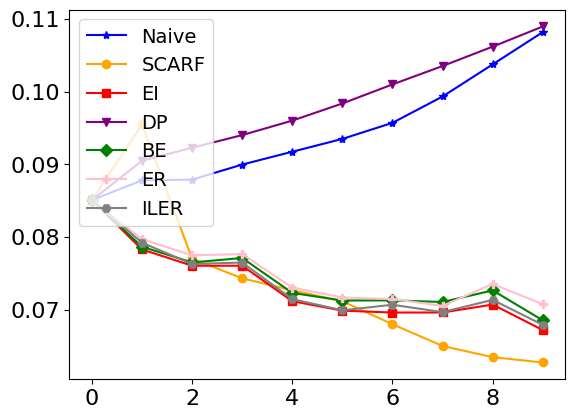

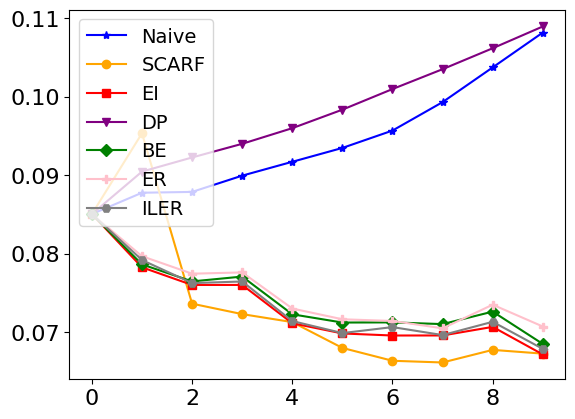

In [ ]:
timeline = range(seq_len)
dataset = 'toy'

b_list = [0.5, 1, 2, 4]
for _b in b_list:
    budget = _b * seq_len

    EI_fairness = np.load(f'ei_fairness_toy_budget_{budget}.npy')
    BE_fairness = np.load(f'be_fairness_toy_budget_{budget}.npy')
    BE_accuracy = np.load(f'be_accuracy_toy_budget_{budget}.npy')
    ER_fairness = np.load(f'er_fairness_toy_budget_{budget}.npy')
    ER_short_term = np.load(f'er_short_term_toy_budget_{budget}.npy')
    ER_accuracy = np.load(f'er_accuracy_toy_budget_{budget}.npy')
    ILER_fairness = np.load(f'iler_fairness_toy_budget_{budget}.npy')
    ILER_accuracy = np.load(f'iler_accuracy_toy_budget_{budget}.npy')
    ILER_short_term = np.load(f'iler_short_term_toy_budget_{budget}.npy')
    EI_fairness_tl = np.mean(EI_fairness, axis=0)
    DP_fairness_tl = np.mean(DP_fairness, axis=0)
    BE_fairness_tl = np.mean(BE_fairness, axis=0)
    BE_fairness_tl = np.mean(BE_fairness, axis=0)
    ER_fairness_tl = np.mean(ER_fairness, axis=0)
    ILER_fairness_tl = np.mean(ILER_fairness, axis=0)
    model_fairness_lstm = np.load('lt_fairness_budget_toy_' + str(budget) + '.npy')
    og_fairness = np.load('og_fairness_toy.npy')
    og_fairness_tl = np.mean(og_fairness, axis=0)
    model_fairness_tl_lstm = np.mean(model_fairness_lstm, axis=0)
    model_fairness_lstm_top = model_fairness_tl_lstm + np.std(model_fairness_lstm, axis=0)
    model_fairness_lstm_bottom = model_fairness_tl_lstm - np.std(model_fairness_lstm, axis=0)
    model_fairness_lstm_top[0] = og_fairness_tl[0] + np.std(og_fairness, axis=0)[0]
    model_fairness_lstm_bottom[0] = og_fairness_tl[0] - np.std(og_fairness, axis=0)[0]
    og_fairness_tl = np.mean(og_fairness, axis=0)
    model_fairness_tl_lstm[0] = og_fairness_tl[0]
    EI_fairness_tl[0] = og_fairness_tl[0]
    DP_fairness_tl[0] = og_fairness_tl[0]

    fig, ax = plt.subplots()

    ax.plot(timeline, og_fairness_tl, color='blue', label='Naive', marker="*")
    ax.plot(timeline, model_fairness_tl_lstm, color='orange', label='SCARF', marker="o")
    # ax.fill_between(timeline,
    #                 model_fairness_lstm_bottom,
    #                 model_fairness_lstm_top,
    #                 color='orange', alpha=0.3, label='SCARF Std. Dev.')
    ax.plot(timeline, EI_fairness_tl, color='red', label='EI', marker="s")
    ax.plot(timeline, DP_fairness_tl, color='purple', label='DP', marker="v")
    ax.plot(timeline, BE_fairness_tl, color='green', label='BE', marker="D")
    ax.plot(timeline, ER_fairness_tl, color='pink', label='ER', marker="P")
    ax.plot(timeline, ILER_fairness_tl, color='gray', label='ILER', marker="H")

    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=14, loc = 'upper left')

    plt.savefig("Toy Results - 30 seeds averaged budget = " + str(budget) + ", epsilon = "+eps+", beta = "+bet+".png")
    plt.show()

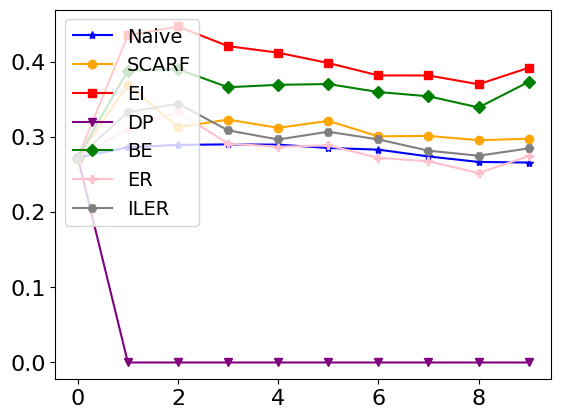

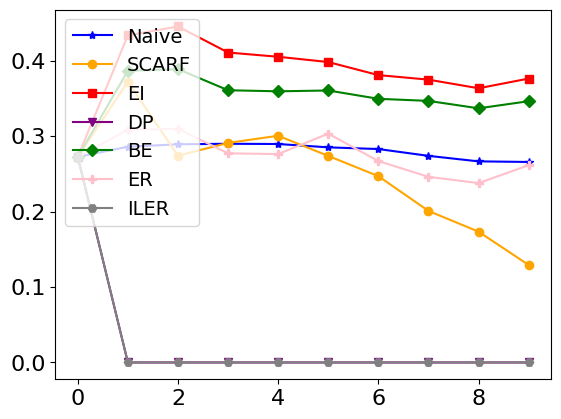

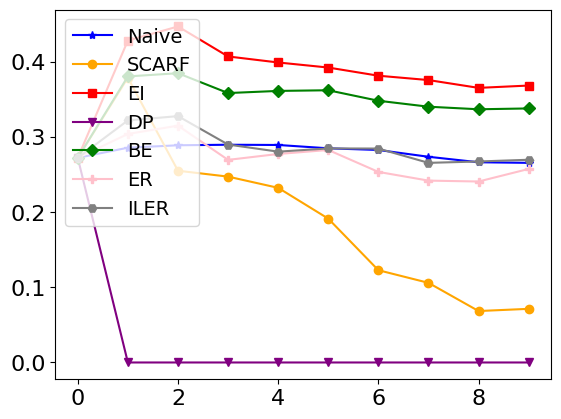

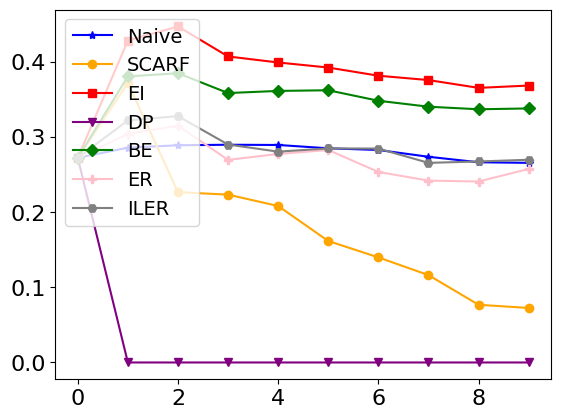

In [54]:
b_list = [0.5, 1, 2, 4]
for _b in b_list:
    budget = _b * seq_len
    EI_short_term = np.load(f'ei_short_term_toy_budget_{budget}.npy')
    BE_short_term = np.load(f'be_short_term_toy_budget_{budget}.npy')
    ER_short_term = np.load(f'er_short_term_toy_budget_{budget}.npy')
    ILER_short_term = np.load(f'iler_short_term_toy_budget_{budget}.npy')
    og_short_term = np.load('st_fairness_og_toy.npy')
    short_term_fairness = np.load('st_fairness_budget_toy_' + str(budget) + '.npy')
    short_term_fairness = np.load('st_fairness_budget_toy_' + str(budget) + '.npy')
    short_term_lstm_tl = np.mean(short_term_fairness, axis=0)
    og_short_term_tl = np.mean(og_short_term, axis=0)
    short_term_lstm_tl[0] = og_short_term_tl[0]
    EI_short_tl = np.mean(EI_short_term, axis=0)
    DP_short_tl = np.mean(DP_short_term, axis=0)
    BE_short_term_tl = np.mean(BE_short_term, axis=0)
    ER_short_term_tl = np.mean(ER_short_term, axis=0)
    ILER_short_term_tl = np.mean(ILER_short_term, axis=0)
    EI_short_tl[0] = og_short_term_tl[0]
    DP_short_tl[0] = og_short_term_tl[0]
    BE_short_term_tl[0] = og_short_term_tl[0]
    ER_short_term_tl[0] = og_short_term_tl[0]
    ILER_short_term_tl[0] = og_short_term_tl[0]

    fig, ax = plt.subplots()

    ax.plot(timeline, og_short_term_tl, color='blue', label='Naive', marker = "*")
    ax.plot(timeline, short_term_lstm_tl, color='orange', label='SCARF', marker = "o")
    # ax.fill_between(timeline,
    #                 short_term_lstm_bottom,
    #                 short_term_lstm_top,
    #                 color='orange', alpha=0.3, label='SCARF Std. Dev.')
    ax.plot(timeline, EI_short_tl, color='red', label='EI', marker = "s")
    ax.plot(timeline, DP_short_tl, color='purple', label='DP', marker = "v")
    ax.plot(timeline, BE_short_term_tl, color='green', label='BE', marker = "D")
    # plt.plot(timeline, short_term_clf_tl, color='orange', label='Post Interventions Short Term Fairness LSTM CLF', marker = "x")
    ax.plot(timeline, ER_short_term_tl, color='pink', label='ER', marker = "P")
    ax.plot(timeline, ILER_short_term_tl, color='gray', label='ILER', marker = "H")

    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=14, loc = 'upper left')

    plt.savefig("Toy Short Term Results - 30 seeds averaged budget = " + str(budget) + ", epsilon = "+eps+", beta = "+bet+".png")
    # plt.savefig("Toy Short Term Results - 30 seeds averaged budget = " + str(budget) + ", reduced causal factors.png")

    plt.show()

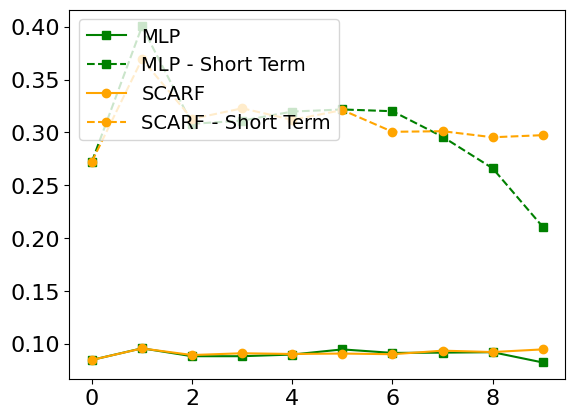

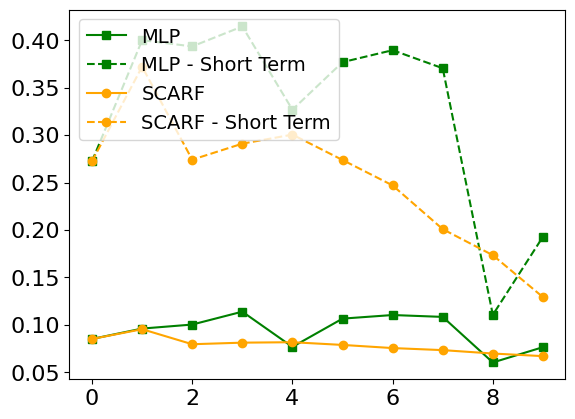

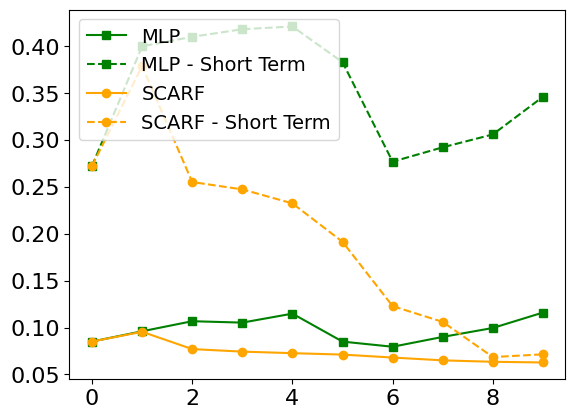

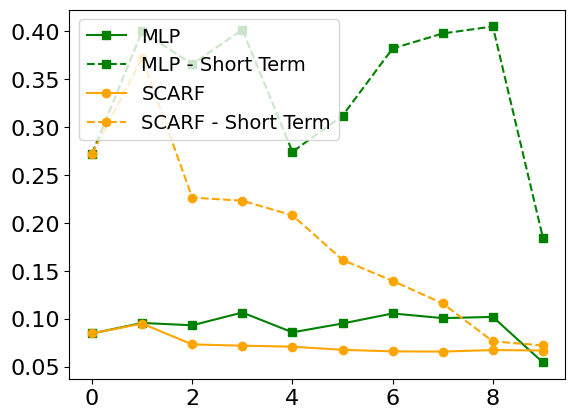

In [82]:
b_list = [0.5, 1, 2, 4]
for b in b_list:
    nn_fairness = np.load(f'lt_fairness_nn_budget_toy_{b*seq_len}.npy')
    nn_short_term = np.load(f'st_fairness_nn_budget_toy_{b*seq_len}.npy')
    nn_fairness_tl = np.mean(nn_fairness, axis=0)
    nn_short_term_tl = np.mean(nn_short_term, axis=0)
    lstm_fairness = np.load('lt_fairness_budget_toy_' + str(b*seq_len) + '.npy')
    lstm_short_term = np.load('st_fairness_budget_toy_' + str(b*seq_len) + '.npy')
    lstm_fairness_tl = np.mean(lstm_fairness, axis=0)
    lstm_short_term_tl = np.mean(lstm_short_term, axis=0)
    og_fairness = np.load('og_fairness_toy.npy')
    og_fairness_tl = np.mean(og_fairness, axis=0)
    og_short_term = np.load('st_fairness_og_toy.npy')
    og_short_term_tl = np.mean(og_short_term, axis=0)
    nn_fairness_tl[0] = og_fairness_tl[0]
    nn_short_term_tl[0] = og_short_term_tl[0]
    lstm_fairness_tl[0] = og_fairness_tl[0]
    lstm_short_term_tl[0] = og_short_term_tl[0]
    timeline = range(seq_len)
    fig, ax = plt.subplots()
    ax.plot(timeline, nn_fairness_tl, color='green', label='MLP', marker = "s")
    ax.plot(timeline, nn_short_term_tl, color='green', linestyle='dashed', label='MLP - Short Term', marker = "s")
    ax.plot(timeline, lstm_fairness_tl, color='orange', label='SCARF', marker = "o")
    ax.plot(timeline, lstm_short_term_tl, color='orange', linestyle='dashed', label='SCARF - Short Term', marker = "o")
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=14, loc = 'upper left')
    plt.savefig(f'Toy Long Term vs Short Term Fairness, Budget = {b*seq_len}, Ablation.png')
    plt.show()

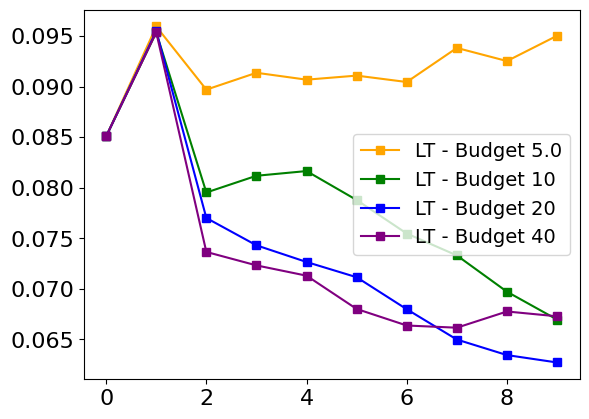

In [124]:
b_list = [0.5, 1, 2, 4]
color_list = ['orange', 'green', 'blue', 'purple']

og_fairness = np.load('og_fairness_toy.npy')
og_fairness_tl = np.mean(og_fairness, axis=0)
og_short_term = np.load('st_fairness_og_toy.npy')
og_short_term_tl = np.mean(og_short_term, axis=0)

fig, ax = plt.subplots()

for idx, b in enumerate(b_list):
    lstm_fairness = np.load('lt_fairness_budget_toy_' + str(b*seq_len) + '.npy')
    lstm_fairness_tl = np.mean(lstm_fairness, axis=0)
    
    lstm_fairness_tl[0] = og_fairness_tl[0]
    timeline = range(seq_len)
    ax.plot(timeline, lstm_fairness_tl, color=color_list[idx], label=f'LT - Budget {b*seq_len}', marker = "s")
    #ax.plot(timeline, lstm_short_term_tl, color=color_list[idx], linestyle='dashed', label=f'ST - Budget {b*seq_len}', marker = "s")

ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=14)
plt.savefig(f'Toy Budget Sensitivity Long Term.png')
plt.show()

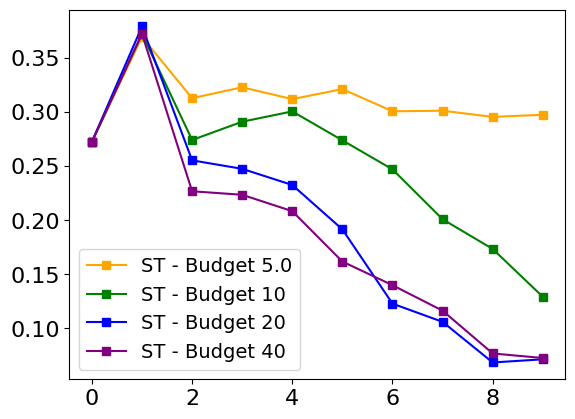

In [123]:
b_list = [0.5, 1, 2, 4]
color_list = ['orange', 'green', 'blue', 'purple']

og_fairness = np.load('og_fairness_toy.npy')
og_fairness_tl = np.mean(og_fairness, axis=0)
og_short_term = np.load('st_fairness_og_toy.npy')
og_short_term_tl = np.mean(og_short_term, axis=0)
    

fig, ax = plt.subplots()

for idx, b in enumerate(b_list):
    lstm_short_term = np.load('st_fairness_budget_toy_' + str(b*seq_len) + '.npy')
    lstm_short_term_tl = np.mean(lstm_short_term, axis=0)
    lstm_short_term_tl[0] = og_short_term_tl[0]
    timeline = range(seq_len)
    ax.plot(timeline, lstm_short_term_tl, color=color_list[idx], label=f'ST - Budget {b*seq_len}', marker = "s")

ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=14)
plt.savefig(f'Toy Budget Sensitivity Short Term.png')
plt.show()

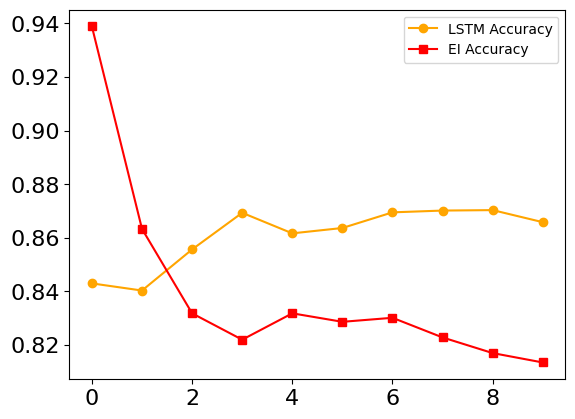

In [ ]:
for _b in b_list:
    budget = _b * seq_len
    lstm_accuracy = np.load('lstm_accuracy_budget_toy_' + str(budget) + '.npy')
    lstm_accuracy = 1 - lstm_accuracy
    ei_accuracy = np.load('ei_accuracy_toy_budget_' + str(budget) + '.npy')
    ei_accuracy = 1 - ei_accuracy
    lstm_accuracy_tl = np.mean(lstm_accuracy, axis=0)
    ei_accuracy_tl = np.mean(ei_accuracy, axis=0)
    timeline = range(seq_len)
    fig, ax = plt.subplots()
    ax.plot(timeline, lstm_accuracy_tl, color='orange', label='LSTM Accuracy', marker = "o")
    ax.plot(timeline, ei_accuracy_tl, color='red', label='EI Accuracy', marker = "s")
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=14)
    #plt.title(f'Accuracy Loss, Dataset = Synthetic, Budget = {budget}')
    plt.savefig(f'Toy Accuracy, Budget = {budget}.png')
    plt.legend()
    plt.show()